Forecast Annual Visition at Utah National Parks

In [0]:
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

# Ingest Data

Visition data for each park is stored in its own csv file. We collect all data into a single pandas dataframe

In [0]:
# all files in directory
all_files = os.listdir()

# just the csv's with data
csv_files = [file for file in all_files if file.endswith(".csv")]

In [0]:
# initialize the final dataset and types

# set columns and types
data = ["ts", "visitors", "park"]

# make dataframe
df_visit = pd.DataFrame(columns=data)

In [0]:
# loop through datasets

for f in csv_files:

    # extract name of park from data
    park_name = pd.read_csv(f, nrows=1).iloc[0, 0]
    # trim the ' NP' from park name
    park_name = park_name[:-3]

    # read data
    df = pd.read_csv(f, skiprows=3)
    # drop last column since it's a row-wise sum
    df.drop(df.columns[-1], axis=1, inplace=True)
    # rename id column
    df.rename(columns={"Year": "year"}, inplace=True)

    # pivot data
    df_pivot = df.melt(
        id_vars="year", var_name="month_abbr", value_name="visitors"
    ).dropna()

    # clean data
    # extract month number from month name
    def extract_month_number(month_name):
        return pd.to_datetime(month_name, format="%b").month

    df_pivot["month_num"] = df_pivot["month_abbr"].apply(extract_month_number)
    # make timestamp
    df_pivot["ts"] = pd.to_datetime(
        dict(year=df_pivot.year, month=df_pivot.month_num, day=1)
    )
    # convert visitors to numeric
    df_pivot["visitors"] = pd.to_numeric(df_pivot["visitors"].str.replace(",", ""))
    # add park identifier
    df_pivot["park"] = park_name
    # select needed columns
    df_final = df_pivot[["ts", "visitors", "park"]]

    df_visit = pd.concat([df_visit, df_final], ignore_index=True)

In [0]:
# clean data types
df_visit = df_visit.convert_dtypes()

# Exploratory Data Analysis

In [0]:
# set colors
# use brand colors of Mighty 5 campaign (https://www.visitutah.com/places-to-go/parks-outdoors/the-mighty-5)
orange = "#ed6417"
d_blue = "#012d50"
red = "#772116"
l_blue = "#51b8f3"
gray = "#516c85"

colors = [orange, d_blue, red, l_blue, gray]

## Overall Visitation

We have data starting in 1979 for each park. Each has a monthly observation through March 2024

In [0]:
(
    df_visit.groupby("park")
    .agg(
        tot_visitors=("visitors", "sum"),
        ts_min=("ts", "min"),
        ts_max=("ts", "max"),
        tot_months=("ts", "count"),
    )
    .sort_values("tot_visitors", ascending=False)
)

,tot_visitors,ts_min,ts_max,tot_months
park,,,,
Zion,119799075,1979-01-01,2024-03-01,543
Bryce Canyon,54430540,1979-01-01,2024-03-01,543
Arches,39894589,1979-01-01,2024-03-01,543
Capitol Reef,30093495,1979-01-01,2024-03-01,543
Canyonlands,18593469,1979-01-01,2024-03-01,543


Visitation grew in the late 80's and stabilized for about 20 years. It then spiked in the 2010's with the Mighty 5 campaign.

There was a dip in 2020 due to covid retrictions

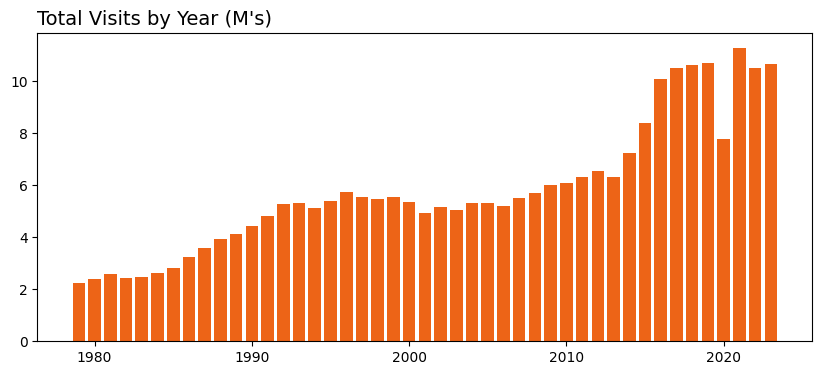

In [0]:
visits_by_year = (
    df_visit.loc[
        (df_visit["ts"].dt.year < 2024)
    ]  # filter current year since it's incomplete
    .groupby(df_visit["ts"].dt.year)
    .agg(tot_visitors=("visitors", "sum"))
    .reset_index()
    .rename(columns={"ts": "year"})
)

visits_by_year["ms_visitors"] = visits_by_year["tot_visitors"] / 1000000  # get M's

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 4))

ax.bar(visits_by_year["year"], visits_by_year["ms_visitors"], color=[orange])

ax.set_title("Total Visits by Year (M's)", fontsize=14, loc="left")

# Display the plot
plt.show()

## Visitation by Park

All parks experienced a similar growth **trend** in visitation.   

The ranking of the parks has remained stable for nearly the whole dataset. Zion is the most visited and Canyonlands the least

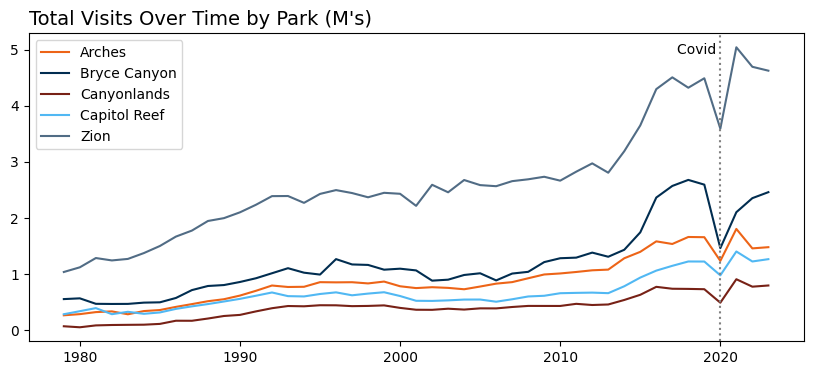

In [0]:
visits_by_year_by_park = (
    df_visit.loc[
        (df_visit["ts"].dt.year < 2024)
    ]  # filter current year since it's incomplete
    .groupby([df_visit["ts"].dt.year, "park"])
    .agg(tot_visitors=("visitors", "sum"))
    .reset_index()
    .rename(columns={"ts": "year"})
)

visits_by_year_by_park["ms_visitors"] = (
    visits_by_year_by_park["tot_visitors"] / 1000000
)  # get M's

# Create the line plot
fig, ax = plt.subplots(figsize=(10, 4))

i = 0

for park, data in visits_by_year_by_park.groupby("park"):
    ax.plot(data["year"], data["ms_visitors"], label=park, color=colors[i])
    i += 1

ax.set_title("Total Visits Over Time by Park (M's)", fontsize=14, loc="left")

ax.axvline(2020, color="gray", linestyle=":")
ax.text(2020, 5, "Covid ", horizontalalignment="right", verticalalignment="center")

ax.legend()

# Display the plot
plt.show()

There is clear **seasonality** in visitation.

Visits increase during the summer months

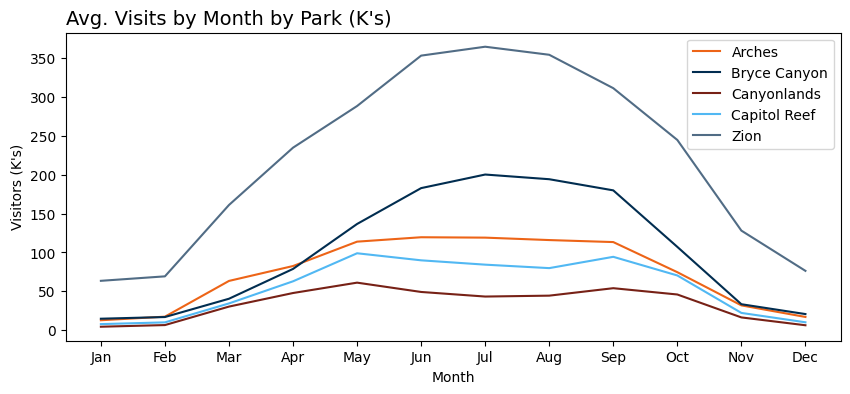

In [0]:
visits_by_month_by_park = (
    df_visit.loc[df_visit["ts"].dt.year < 2024] # filter current year since it's incomplete
    .assign(month=df_visit["ts"].dt.month)
    .assign(month_name=df_visit['ts'].dt.strftime('%b'))
    .groupby(['month', 'month_name', 'park'])
    .agg(avg_visitors=("visitors", "mean"))
    .reset_index()
)

visits_by_month_by_park["ks_visitors"] = (
    visits_by_month_by_park["avg_visitors"] / 1000
)  # get K's

#sort by order of months
visits_by_month_by_park = visits_by_month_by_park.sort_values("month")

# Create the line plot
fig, ax = plt.subplots(figsize=(10, 4))

i = 0

#plot each series
for park, data in visits_by_month_by_park.groupby("park"):
    ax.plot(data["month_name"], data["ks_visitors"], label=park, color=colors[i])
    i += 1

#set labels
ax.set_title("Avg. Visits by Month by Park (K's)", fontsize=14, loc="left")
ax.set_xlabel("Month")
ax.set_ylabel("Visitors (K's)")

ax.legend()

# Display the plot
plt.show()

Here is the overall visition by park.

Notice the increasing trend and strong seasonality

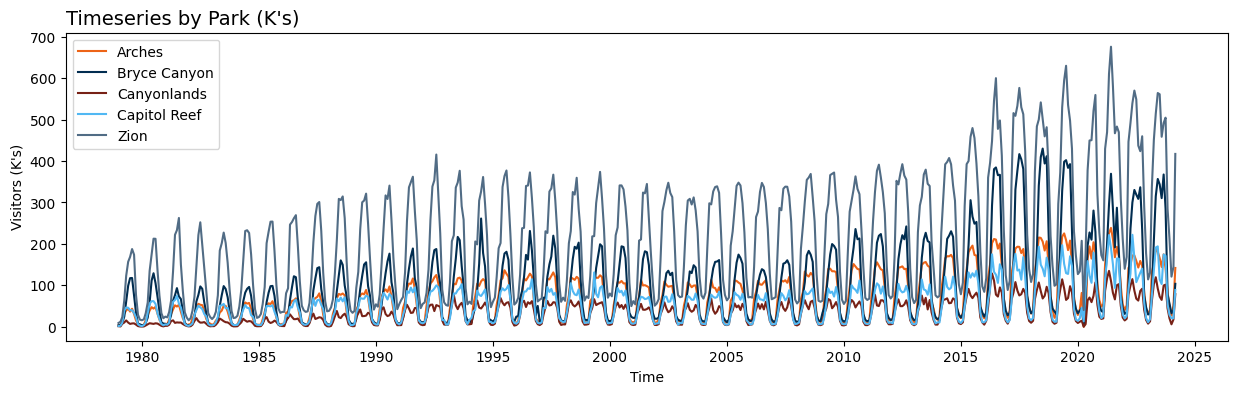

In [0]:
df_total = df_visit.copy()

df_total["ks_visitors"] = (
    df_total["visitors"] / 1000
)  # get K's

#sort on ts
df_total = df_total.sort_values("ts")

# Create the line plot
fig, ax = plt.subplots(figsize=(15, 4))

i = 0

#plot each series
for park, data in df_total.groupby("park"):
    ax.plot(data["ts"], data["ks_visitors"], label=park, color=colors[i])
    i += 1

#set labels
ax.set_title("Timeseries by Park (K's)", fontsize=14, loc="left")
ax.set_xlabel("Time")
ax.set_ylabel("Visitors (K's)")

ax.legend()

# Display the plot
plt.show()

Let's zoom in on that covid year.

The total visition was down and the peak visitation shifted to later in the year. We'll have to account for that in the model

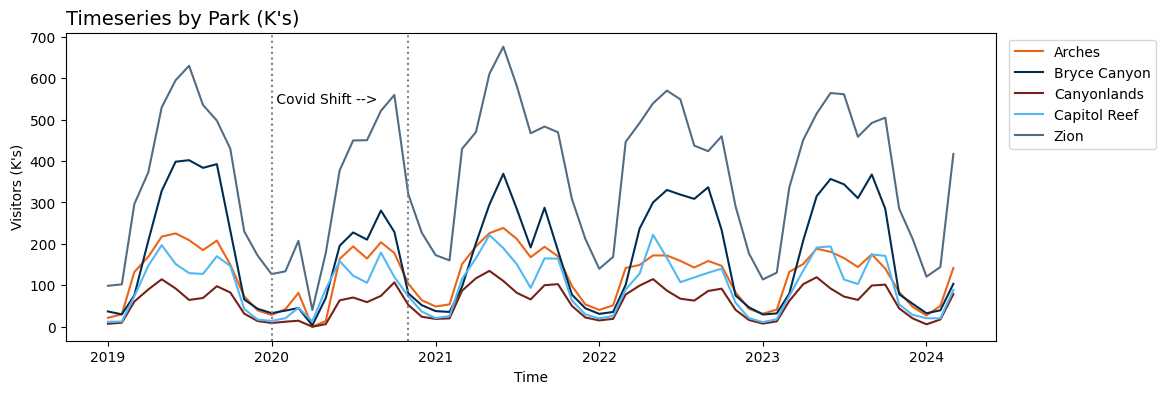

In [0]:
df_covid = df_visit.copy()

df_covid["ks_visitors"] = (
    df_covid["visitors"] / 1000
)  # get K's

df_covid = (
  df_covid.loc[df_covid["ts"].dt.year > 2018] # filter to covid range
)

#sort on ts
df_covid = df_covid.sort_values("ts")

# Create the line plot
fig, ax = plt.subplots(figsize=(12, 4))

i = 0

#plot each series
for park, data in df_covid.groupby("park"):
    ax.plot(data["ts"], data["ks_visitors"], label=park, color=colors[i])
    i += 1

#set labels
ax.set_title("Timeseries by Park (K's)", fontsize=14, loc="left")
ax.set_xlabel("Time")
ax.set_ylabel("Visitors (K's)")

ax.legend(loc='upper right', bbox_to_anchor=(1.18, 1)) # Set the legend position outside the plot area

covid_start = '2020-01-01'
covid_end = '2020-11-01'
ax.axvline(np.datetime64(covid_start), color="gray", linestyle=":")
ax.axvline(np.datetime64(covid_end), color="gray", linestyle=":")
ax.text(np.datetime64(covid_start), 540, " Covid Shift -->", horizontalalignment="left")

# Display the plot
plt.show()

# Modeling

For this project, I will be using the Prophet algorithm developed by meta. Read the docs [here](https://facebook.github.io/prophet/).

The algorithm takes a bayesian approach to estimating the trend and seasonality of the time series to inference future values. 

import packages for time series modeling

In [0]:
from prophet import Prophet

Let's set up a dataframe with the time series for just one park for a simple example 

In [0]:
park = 'Arches'

df_arches = (
    df_visit.loc[(df_visit["park"] == park)]
    .rename(columns={"visitors": "y",
                     "ts": "ds"}) #rename for prophet
    .sort_values('ds')
)

df_arches

,ds,y,park
2217,1979-01-01,2970,Arches
2263,1979-02-01,3135,Arches
2309,1979-03-01,14659,Arches
2354,1979-04-01,31818,Arches
2399,1979-05-01,39266,Arches
...,...,...,...
2625,2023-11-01,83843,Arches
2670,2023-12-01,48037,Arches
2172,2024-01-01,27174,Arches
2218,2024-02-01,50517,Arches


## Base Model

Let's do a base model with the standard parameters

In [0]:

model = Prophet() #instantiate a model
model.fit(df_arches) #fit onto the historical data

periods = 33 #forecast 33 months into the future (through 2026)
future = model.make_future_dataframe(periods=periods, freq = 'MS') #make a monthly future dataset
forecast = model.predict(future) #predict over future dates

23:13:42 - cmdstanpy - INFO - Chain [1] start processing
23:13:42 - cmdstanpy - INFO - Chain [1] done processing


Let's explore the forecast

Let's break down this chart:
- the solid blue line is the forecasted yhat value
- the light blue line is the uncertainty
- the black dots are the actual observed values
- time is on the x-axis and visitors is on the y-axis

The model seems to do a poor job at the beginning and end of the series. This suggests a multiplicative growth instead of an additive growth could do better

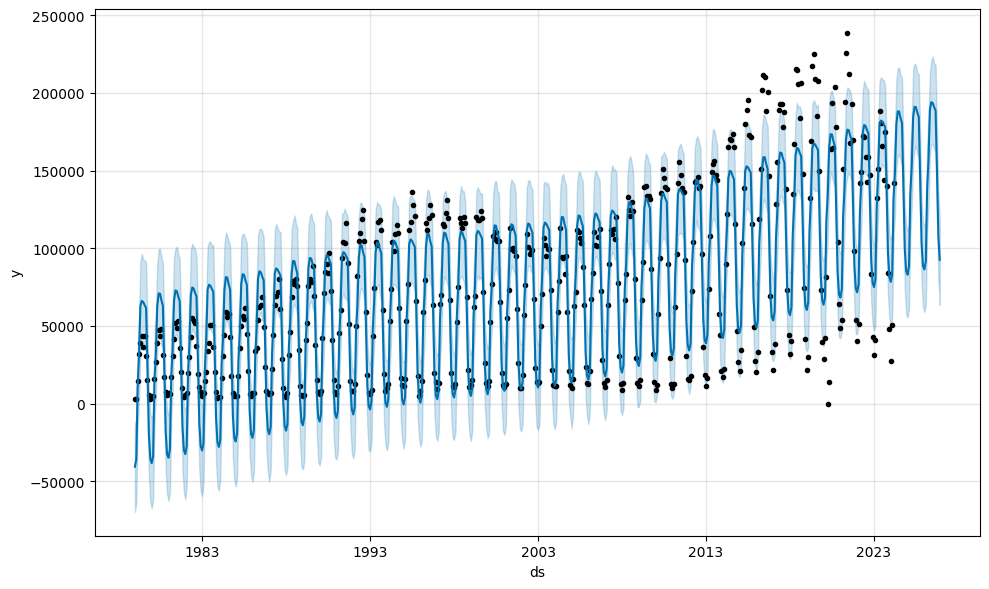

In [0]:
plt = model.plot(forecast)

Here we can see the model picked up the linerar trend of growing visitors. It also found the seasonlity we discovered during our eploratry analysis

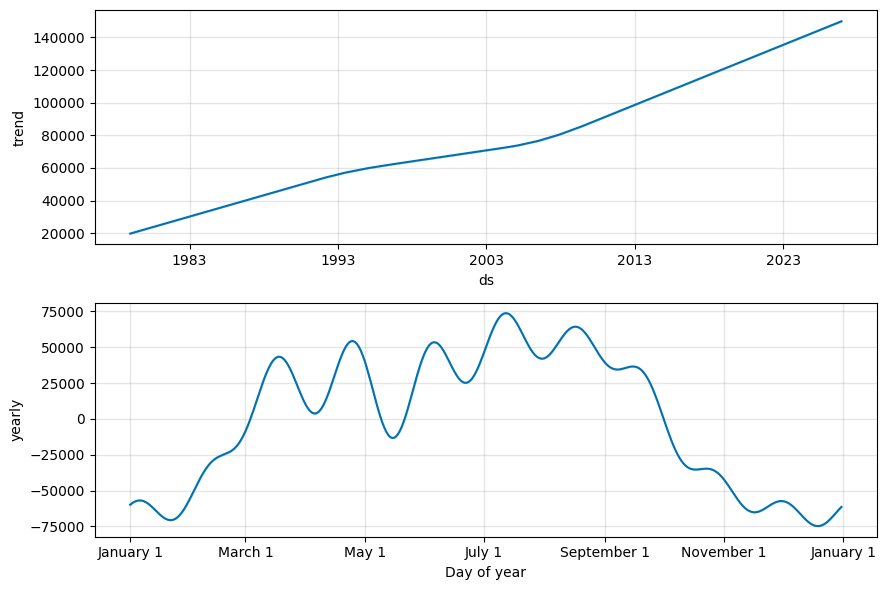

In [0]:
plt = model.plot_components(forecast)

In [0]:
df_arches.count()

ds      543
y       543
park    543
dtype: int64

In [0]:
#test